# Gaussian process regression

In [38]:
import matplotlib.pyplot as plt
import numpy as np

from pyinla.model import *
from pyinla.spde import *

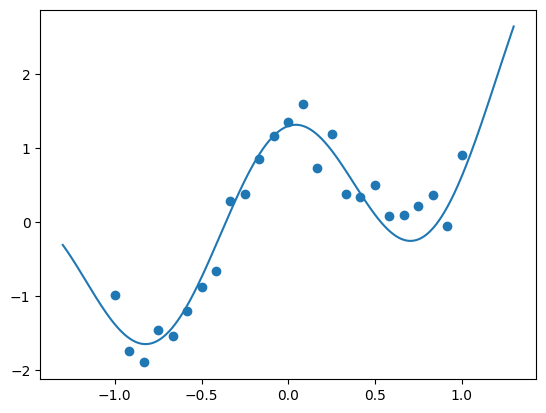

In [3]:
n_train = 25
n_test = 400
sigma_obs = 0.3

fn = (
    lambda x: 20.0 * np.sin(x / 40.0)
    + 0.1 * np.power(x, 3.0)
    + 0.1 * np.power(1.0 + x, 3.0)
    + 1.2 * np.cos(4.0 * x)
)

x = np.linspace(-1, 1, n_train)
y = fn(x)
y += sigma_obs * np.random.normal(size=(n_train,))
y -= np.mean(y)
y /= np.std(y)

x_test = np.linspace(-1.3, 1.3, n_test)

x_true = np.linspace(-1.3, 1.3, 1000)
y_true = fn(x_true)

plt.scatter(x, y)
plt.plot(x_true, y_true)

In [4]:
mesh = mesh_1d(x_test, degree=2)

In [31]:
sigma = 3 * np.std(y)
rho = 0.5 * np.max(x) - np.min(x)
spde = spde2_pcmatern(mesh, alpha=2, prior_range=rho, prior_sigma=sigma)

In [32]:
A = make_projection_matrix(mesh, loc=x)
Ap = make_projection_matrix(mesh, loc=x_test)
index = spde.make_index("ix")

In [33]:
st_est = inla_stack(tag="est", data=dict(y=y), A=A, effects=dict(), index=index)
st_pred = inla_stack(
    tag="pred",
    data=dict(y=np.repeat(np.nan, x_test.size)),
    A=Ap,
    effects=dict(),
    index=index,
)
st_full = combine_stacks(st_est, st_pred)

In [39]:
formula = "y ~ -1 + f(ix, model=spde)"
data = stack_data(st_full) | dict(spde=spde)
data["spde"] = spde
res = inla(
    formula,
    data=data,
    family="gaussian",
    control_predictor=dict(A=stack_A(st_full), compute=True),
)

In [40]:
res

Time used:
     = 1.36,  = 0.182,  = 0.00882,  = 1.56 
Random effects:
  Name	  Model
    ix SPDE2 model

Model hyperparameters:
                                         mean    sd 0.025quant 0.5quant
Precision for the Gaussian observations 22.52 10.39       8.44    20.53
                                        0.975quant  mode
Precision for the Gaussian observations      48.10 17.14

Marginal log-Likelihood:  -26.02 
 is computed 
Posterior summaries for the linear predictor and the fitted values are computed
(Posterior marginals needs also 'control.compute=list(return.marginals.predictor=TRUE)')


In [43]:
pred_ix = stack_index(st_full, tag="pred")
fitted = pd.DataFrame(res.get_summary("fitted.values"))
fitted = fitted.iloc[pred_ix]
fitted["x"] = x_test

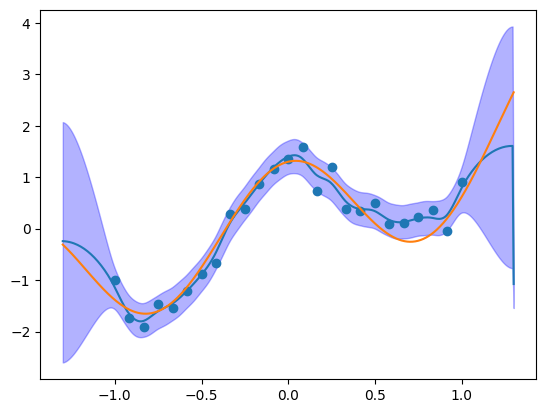

In [44]:
plt.plot(fitted["x"], fitted["mode"])
plt.fill_between(
    fitted["x"], fitted["0.025quant"], fitted["0.975quant"], alpha=0.3, color="b"
)
plt.scatter(x, y)
plt.plot(x_true, y_true)